# Linear Autoencoder vs PCA on a Synthetic 10‑D Dataset 

This notebook builds a synthetic 10‑D dataset and compares **linear autoencoders (AEs)** and **PCA** as reconstruction models. We:

1. Generate a n-D dataset with noise.
2. Standardize with train statistics.
3. Train **linear AEs with tied weights** for latent dims $k=1..10$ and compute **mean test MSE**.
4. Compute **PCA reconstructions** for $k=1..10$ (via `torch.linalg.svd`) and **mean test MSE**.
5. Plot a bar chart (histogram style) comparing AE vs PCA MSE vs $k$.

In [1]:
import math
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Device (CPU is perfectly fine here)
device = (
    torch.device('cuda') if torch.cuda.is_available() else
    (torch.device('mps') if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else torch.device('cpu'))
)
device

device(type='mps')

## 1) Synthetic 10‑D dataset
We sample latent $z\in\mathbb{R}^r$ (with $r=3$) and map it linearly into $\mathbb{R}^{10}$, then add small Gaussian noise. Finally, we standardize using **train** mean/std.

In [61]:
def make_synthetic_dataset(d=10, r=10, n_train=10000, n_test=2000, noise_std=0.4):
    assert r <= d
    # random orthonormal basis (Q) via QR
    Q, _ = torch.linalg.qr(torch.randn(d, d))
    # decreasing singular values to set energy per latent dim
    S = torch.ones(r) * 1.0 
    W = Q[:, :r] @ torch.diag(S)  # (d, r)

    def sample(n):
        z = torch.randn(n, r)
        x = z @ W.T  # (n, d)
        x = x + noise_std * torch.randn_like(x)
        return x

    X_train = sample(n_train)
    X_test = sample(n_test)
    return X_train, X_test

def standardize_train_test(X_train, X_test, eps=1e-8):
    mean = X_train.mean(0, keepdim=True)
    std = X_train.std(0, unbiased=False, keepdim=True).clamp_min(eps)
    return (X_train-mean)/std, (X_test-mean)/std, mean, std

d = 10
X_train_raw, X_test_raw = make_synthetic_dataset(d=d, r=10, n_train=10000, n_test=2000, noise_std=0.05)
X_train, X_test, x_mean, x_std = standardize_train_test(X_train_raw, X_test_raw)
X_train.shape, X_test.shape

(torch.Size([10000, 10]), torch.Size([2000, 10]))

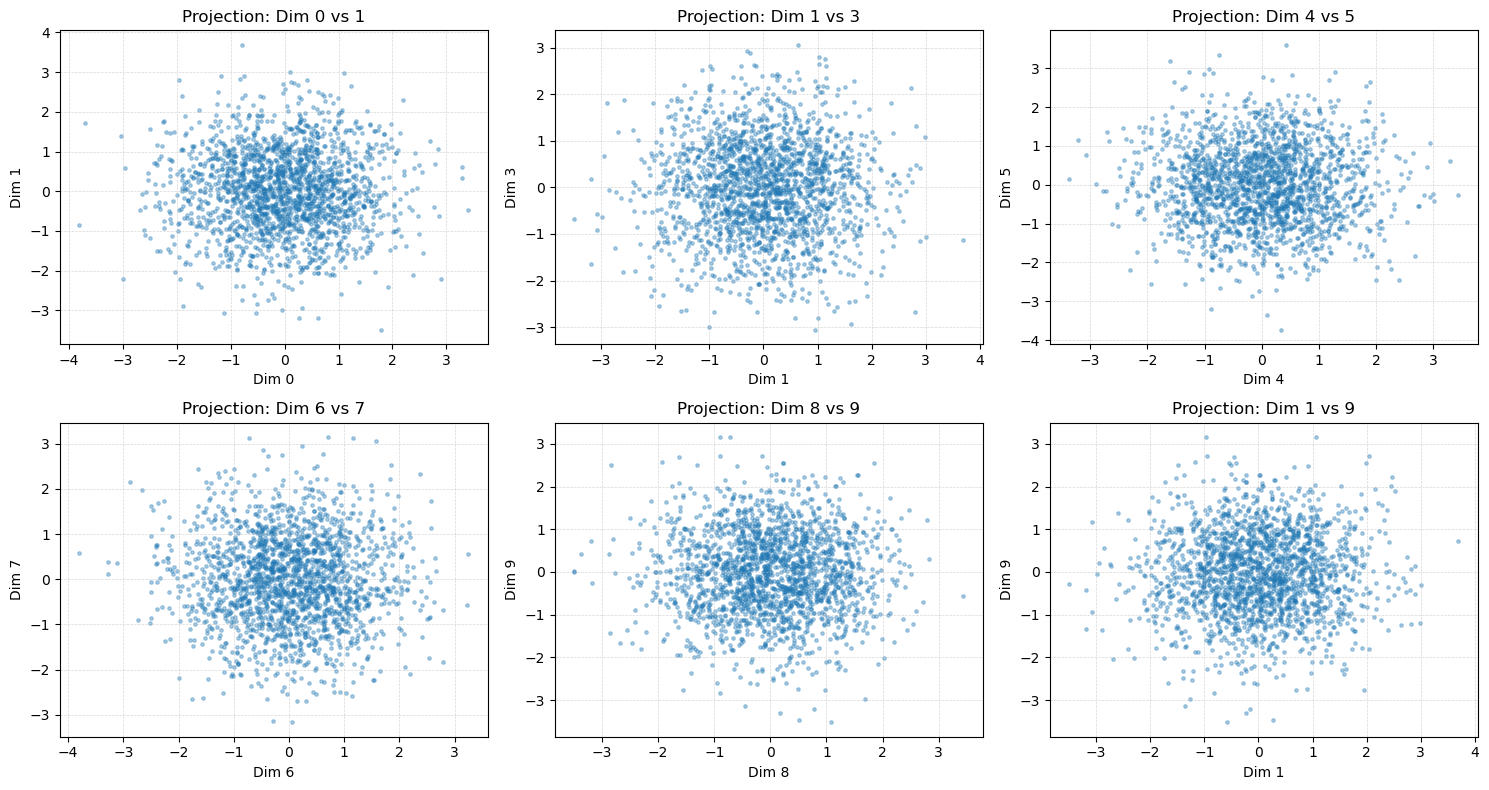

In [62]:
# --- 2D projections of the (standardized) dataset ----------------------------
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from itertools import combinations

def plot_2d_projections(X, pairs=None, max_pairs=6, sample_size=2000, point_size=6, alpha=0.35):
    """
    Plot several 2D projections of X (n_samples, d_features).
    - pairs: list of (i, j) index tuples to plot; if None, uses first `max_pairs` combos.
    - max_pairs: max number of projections to show if pairs is None.
    - sample_size: subsample size for plotting (for speed/clarity).
    """
    assert isinstance(X, torch.Tensor), "X must be a torch.Tensor"
    n, d = X.shape

    # Subsample for plotting
    if n > sample_size:
        idx = torch.randperm(n)[:sample_size]
        Xp = X[idx]
    else:
        Xp = X

    Xp = Xp.to('cpu').numpy()

    # Choose pairs
    if pairs is None:
        all_pairs = list(combinations(range(d), 2))
        pairs = all_pairs[:min(max_pairs, len(all_pairs))]

    p = len(pairs)
    if p == 0:
        print("No pairs to plot (d < 2).")
        return

    # Layout: up to 3 columns
    cols = min(3, p)
    rows = math.ceil(p / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
    axes = axes.flatten()

    for ax, (i, j) in zip(axes, pairs):
        ax.scatter(Xp[:, i], Xp[:, j], s=point_size, alpha=alpha)
        ax.set_xlabel(f"Dim {i}")
        ax.set_ylabel(f"Dim {j}")
        ax.set_title(f"Projection: Dim {i} vs {j}")
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Hide any unused axes
    for k in range(len(pairs), len(axes)):
        axes[k].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
# Show 5 projections: (0,1), (2,3), (4,5), (6,7), (8,9) if d>=10, else first combos.
default_pairs = [(0,1), (1,3), (4,5), (6,7), (8,9), (1,9)] if X_train.shape[1] >= 10 else None
plot_2d_projections(X_train, pairs=default_pairs, max_pairs=6, sample_size=2000)


In [63]:
batch_size = 256
train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True, drop_last=False)
X_test = X_test.to(device)  # move ahead of time

## 2) Linear Autoencoder (tied weights)
A linear AE with **tied weights** uses a single parameter matrix $W\in\mathbb{R}^{k\times d}$ and reconstructs via $\hat{x}=x W^\top W$. The loss is mean squared error.

In [ ]:
class LinearAE(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        # Parameter W: (k, d). Encoding: z = x @ W^T; Decoding: x_hat = z @ W
        self.W = nn.Parameter(torch.randn(k, d) * (1.0 / math.sqrt(d)))
    def forward(self, x):
        # x: (N, d)
        z = x @ self.W.t()      # (N, k)
        x_hat = z @ self.W      # (N, d)
        return x_hat

def train_linear_ae(d, k, train_loader, X_test, epochs=50, lr=1e-2, device=device):
    model = LinearAE(d, k).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss(reduction='mean')
    model.train()
    for ep in range(epochs):
        for (xb,) in train_loader:
            xb = xb.to(device)
            xh = model(xb)
            loss = loss_fn(xh, xb)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        xh = model(X_test)
        test_mse = loss_fn(xh, X_test).item()
    return model, test_mse

ks = list(range(1, d+1))
ae_mse = []
for k in ks:
    _, mse_k = train_linear_ae(d, k, train_loader, X_test, epochs=60, lr=5e-3, device=device)
    ae_mse.append(mse_k)
ae_mse

[0.9063909649848938,
 0.8067142367362976,
 0.711775004863739,
 0.6135187149047852,
 0.5090774297714233,
 0.4067837595939636,
 0.3072158098220825,
 0.201890230178833,
 0.0993310734629631,
 8.133605076889212e-15]

## 3) PCA via `torch.linalg.svd`
We compute the right singular vectors $V$ of the (standardized) train matrix. The top‑$k$ columns of $V$ give the principal directions. Reconstruction on test: $\hat{X}=X V_k V_k^\top$.

In [65]:
import torch
import torch.nn as nn

# Ensure PCA runs on CPU
X_train_cpu = X_train.to('cpu')
X_test_cpu  = X_test.to('cpu')

with torch.no_grad():
    # SVD-based PCA: X ≈ U S V^T  (rows = samples, cols = features)
    U, S, Vh = torch.linalg.svd(X_train_cpu, full_matrices=False)
    V = Vh.T  # (d, d)  <-- use .T so this also looks like numpy if you ever switch

def pca_reconstruct(X, V, k):
    Vk = V[:, :k]         # (d, k)
    return X @ Vk @ Vk.T  # (n, d) @ (d, k) @ (k, d) -> (n, d)

mse = nn.MSELoss(reduction='mean')

ks = list(range(1, X_train_cpu.shape[1] + 1))
pca_mse = []
with torch.no_grad():
    for k in ks:
        Xh = pca_reconstruct(X_test_cpu, V, k)
        pca_mse.append(mse(Xh, X_test_cpu).item())

pca_mse


[0.9071465134620667,
 0.8071132898330688,
 0.7080028057098389,
 0.6091304421424866,
 0.5122370719909668,
 0.41066431999206543,
 0.30715158581733704,
 0.20350325107574463,
 0.09962990134954453,
 1.9623675785469114e-13]

## 4) Results and plot

In [66]:
print("k  |   AE MSE      |   PCA MSE")
print("-- | ------------- | ----------")
for k, a, p in zip(ks, ae_mse, pca_mse):
    print(f"{k:2d} | {a:12.6f} | {p:10.6f}")

k  |   AE MSE      |   PCA MSE
-- | ------------- | ----------
 1 |     0.906391 |   0.907147
 2 |     0.806714 |   0.807113
 3 |     0.711775 |   0.708003
 4 |     0.613519 |   0.609130
 5 |     0.509077 |   0.512237
 6 |     0.406784 |   0.410664
 7 |     0.307216 |   0.307152
 8 |     0.201890 |   0.203503
 9 |     0.099331 |   0.099630
10 |     0.000000 |   0.000000


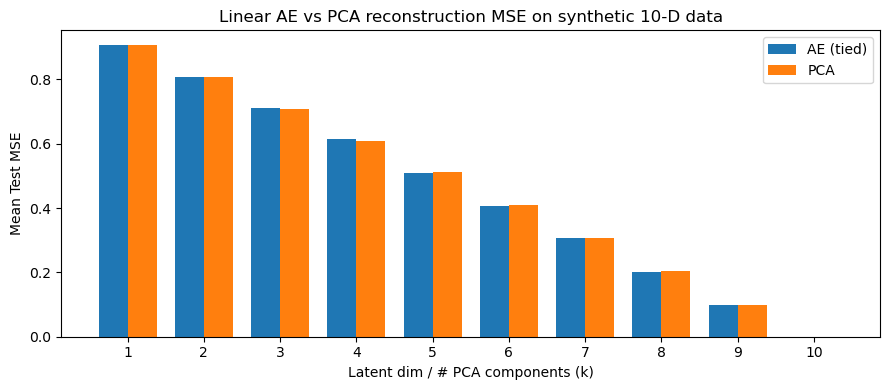

In [67]:
plt.figure(figsize=(9,4))
x = torch.arange(1, d+1).numpy()
width = 0.38
plt.bar(x - width/2, ae_mse, width, label='AE (tied)')
plt.bar(x + width/2, pca_mse, width, label='PCA')
plt.xlabel('Latent dim / # PCA components (k)')
plt.ylabel('Mean Test MSE')
plt.title('Linear AE vs PCA reconstruction MSE on synthetic 10‑D data')
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()